# 基于iGraph的网络分析和绘图

Jul 21, 2024, Hans Cao

iGraph 是一个高效的图处理库，适用于大规模网络分析。Graph 提供了丰富的功能，用于各种网络分析任务，包括图的生成与操作、基本属性与度量、中心性指标、社区检测与聚类、图的可视化以及高级分析功能。通过这些功能，可以进行复杂的网络分析和研究。

下面是一个示例，

In [1]:
import igraph as ig
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_inline import backend_inline
backend_inline.set_matplotlib_formats('svg') 


class MyGraph():
    def __init__(self, adj_matrix):
        """
        adj_matrix: 邻接矩阵
        """
        self.adj_matrix = adj_matrix
        self.init_graph()
        
    def init_graph(self):
        self.g = ig.Graph(directed=True)
        for i in self.adj_matrix.columns:
            self.g.add_vertex(name=i)

        edges = []
        node_labels = self.adj_matrix.columns.values
        weights = []
        for i in range(self.adj_matrix.shape[0]):
            for j in range(self.adj_matrix.shape[0]):
                if self.adj_matrix.iloc[i, j] != 0 and not np.isnan(self.adj_matrix.iloc[i, j]): 
                    edges.append((i, j))
                    weights.append(self.adj_matrix.iloc[i, j])
        self.g.add_edges(edges)
        self.g.vs['name'] = node_labels
        self.g.vs["label"] = self.g.vs['name']
        self.g.es['weight'] = weights


    def profile(self):
        """
        describe network with key indicators
        """
        print('stats profile...')
        g = self.g
        weights = self.g.es['weight']
        properties_dict = {
            "节点数": g.vcount(),
            "边数": g.ecount(),
            '是否有向': g.is_directed(),
            '是否加权': g.is_weighted(),
            "节点度数:": g.degree(),
            '最大度': max(g.degree()),
            '平均度': round(self.adj_matrix.values.sum() / self.adj_matrix.shape[0], 5),
            "网络直径": round(g.diameter(weights=weights), 5),
            "平均路径长度": round(g.average_path_length(), 5),
            "度中心性:": g.strength(weights=weights),
            "接近中心性:": g.closeness(weights=weights),
            "中介中心性:": g.betweenness(weights=weights),
            '特征向量中心性': g.evcent(weights=weights),  # 计算特征向量中心性
            '平均介数中心性betweenness': round(np.mean(g.betweenness(weights=weights)), 5),
            '平均接近中心性closeness': round(np.mean(g.closeness(weights=weights)), 5),
            '聚类系数': round(g.transitivity_undirected(), 5),
        }
        return properties_dict


    def plot_adj_matrix_hist(self, figsize=(6, 4)):
        """
        plot histogram of adj-matrix
        """
        pd.DataFrame(self.adj_matrix.values.flatten()).hist(figsize=figsize)

    
    def plot_circle(self, figsize=(6, 4), vertex_color="lightblue"):
        """
        plot network at form of "circle"
        """
        layout = self.g.layout("circle")  #fr
        visual_style = {
            "vertex_size": 20,
            "vertex_color": "blue",
            "vertex_label": self.g.vs["name"],
            "edge_width": 2,
            "layout": layout
        }
        fig, ax = plt.subplots(figsize=figsize)
        ig.plot(self.g, target=ax, **visual_style)
        plt.show()

    
    def plot_clusters(self, figsize=(6,4), vertex_size=0.5, edge_width=0.7):
        """
        plot network at form of "clusters"
        """
        components = self.g.connected_components()
        fig, ax = plt.subplots(figsize=figsize)
        ig.plot(
            components,
            target=ax,
            palette=ig.RainbowPalette(),
            vertex_size=vertex_size,
            vertex_color=list(map(int, ig.rescale(components.membership, (0, 200), clamp=True))),
            edge_width=edge_width
        )
        plt.show()

    
    def communities_clustering(self):
        """
        使用边介数法进行社区检测
        """
        communities = self.g.community_edge_betweenness()
        clusters = communities.as_clustering()
        print("社区划分:", clusters.membership)


示例

In [2]:
adj_matrix = pd.DataFrame([
    [0, 2, 3, 0, 0],
    [1, 0, 2, 3, 2],
    [1, 3, 0, 1, 1],
    [0, 1, 2, 0, 1],
    [0, 0, 3, 1, 0]
], columns=['A', 'B', 'C', 'D', 'E'])

my_graph = MyGraph(adj_matrix)
my_graph.profile()

stats profile...


{'节点数': 5,
 '边数': 15,
 '是否有向': True,
 '是否加权': True,
 '节点度数:': [4, 7, 8, 6, 5],
 '最大度': 8,
 '平均度': 5.4,
 '网络直径': 4.0,
 '平均路径长度': 1.25,
 '度中心性:': [7.0, 14.0, 16.0, 9.0, 8.0],
 '接近中心性:': [0.6666666666666666,
  0.6666666666666666,
  0.8,
  0.8,
  0.6666666666666666],
 '中介中心性:': [0.0, 2.5, 1.8333333333333333, 3.5, 0.3333333333333333],
 '特征向量中心性': [0.31581578198765786,
  0.771226173589155,
  1.0,
  0.6937253761395688,
  0.5770217341976451],
 '平均介数中心性betweenness': 1.63333,
 '平均接近中心性closeness': 0.72,
 '聚类系数': 0.78947}

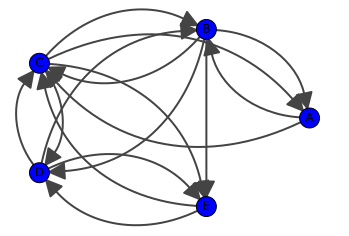

In [3]:
my_graph.plot_circle()

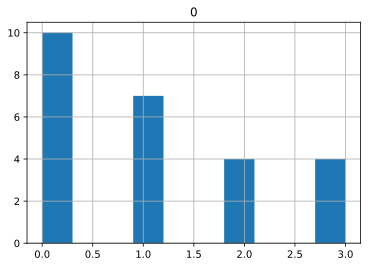

In [4]:
my_graph.plot_adj_matrix_hist()

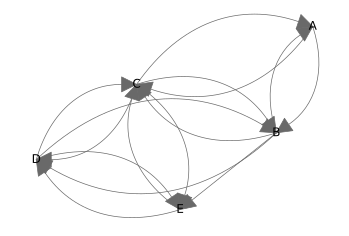

In [5]:
my_graph.plot_clusters()

In [6]:
my_graph.communities_clustering()

社区划分: [0, 0, 0, 0, 0]


In [7]:
my_graph.g.es['weight']

[2, 3, 1, 2, 3, 2, 1, 3, 1, 1, 1, 2, 1, 3, 1]